In [3]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.community as nx_comm
import networkx as nx
from owlready2 import *
from owlready2 import get_ontology
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.community as nx_comm

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [4]:
onto = get_ontology("http://example.org/medsur.owl")

class Patients(Thing):
    namespace = onto

class AgeGroup(Thing):
    namespace = onto
 
class hasAgeGroup(ObjectProperty):                  # TODO: do we need to define ranges for our properties?
    domain = [Patients]
    range = [AgeGroup]
    namespace = onto
  
class WeightGroup(Thing):
    namespace = onto
    
class hasWeightGroup(ObjectProperty):   # is this range correct if we connect patient directly to weightgroup is rdf tripple, else delete range
    domain = [Patients]
    range = [WeightGroup]
    namespace = onto
    
class Symptoms(Thing):
    namespace = onto
    
class hasSymptom(ObjectProperty):
    domain = [Patients]
    range = [Symptoms]
    namespace = onto

class Outcome(Thing):
    namespace = onto
    
class hasOutcome(ObjectProperty):
    domain = [Patients]
    range = [Outcome]
    namespace = onto
    
class Gender(Thing):
    namespace = onto

class hasGender(ObjectProperty):
    domain = [Patients]
    range = [Gender]
    namespace = onto

class Drug(Thing):
    namespace = onto
    
class IsGivenDrug(ObjectProperty):
    domain = [Patients]
    range = [Drug]
    namespace = onto
    
class IsOfDosis(ObjectProperty):
    domain = [Drug]
    namespace = onto
    
class IsOfType(ObjectProperty):
    domain = [Drug]
    namespace = onto

class SideEffects(Thing):
    namespace = onto
    
class hasSideEffect(ObjectProperty):
    domain = [Drug]
    range = [SideEffects]
    namespace = onto
    
class hasFrequency(ObjectProperty):                 
    domain = [SideEffects]
    namespace = onto 


In [5]:
onto.save(file = "medsur.rdf", format = "rdfxml") 
g = rdflib.Graph()
g.parse("medsur.rdf", format="xml")

# Loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    
    # Check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# Print the number of "triples" in the Graph
print(f"Graph g has {len(g)} statements.")

Graph g has 44 statements.


In [6]:
data_patients = pd.read_excel('output_opioid.xlsx')
data_patients.head()

Unnamed: 0  ID WorldwideUniqueCaseIdentification  Status  Category  \
0           0   1                      CF-NL-09-249      40       NaN   
1           1   2                      CF-NL-09-249      40       NaN   
2           2   3       ES-KYOWAKIRIN-2019BKK009955      40       NaN   
3           3   4       ES-KYOWAKIRIN-2019BKK009955      40       NaN   
4           4   5       ES-KYOWAKIRIN-2019BKK009955      40       NaN   

   BodyWeight  Height  BMI BMIGroup date_received  ...  \
0         NaN     NaN  NaN      NaN    2009-12-14  ...   
1         NaN     NaN  NaN      NaN    2009-12-14  ...   
2         NaN     NaN  NaN      NaN    2019-06-19  ...   
3         NaN     NaN  NaN      NaN    2019-06-19  ...   
4         NaN     NaN  NaN      NaN    2019-06-19  ...   

                                            HLTGName   SOCCode  \
0                          Psychiatric disorders NEC  10037175   
1  Therapeutic and nontherapeutic effects (excl t...  10018065   
2                        Parathyroid gland disorders  10014698   
3                           Deliria (incl confusion)  10037175   
4  Bone, calcium, magnesium and phosphorus metabo...  10027433   

                                             SOCName SOCAbbreviation  \
0                              Psychiatric disorders           Psych   
1  General disorders and administration site cond...           Genrl   
2                                Endocrine disorders            Endo   
3                              Psychiatric disorders           Psych   
4                 Metabolism and nutrition disorders           Metab   

   IsCurrent IsDefaultSOC                         Primary Source Description  \
0          1            1  she had become dependant of pain killers and s...   
1          1            1  paracetamol and codeine no longer sufficiently...   
2          1            0                                      Hypercalcemia   
3          1            1                                     Disorientation   
4          1            1                                      Hypercalcemia   

                                             summary  \
0  Automatic summary of the report by the Netherl...   
1  Automatic summary of the report by the Netherl...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                           narrative    Dosage  
0  The following information was published in the...      50MG  
1  The following information was published in the...      50MG  
2  Case reference number 2019BKK009955 is a solic...  100UG/DO  
3  Case reference number 2019BKK009955 is a solic...  100UG/DO  
4  Case reference number 2019BKK009955 is a solic...  100UG/DO  

[5 rows x 41 columns]

In [7]:

data_sideeffects = pd.read_excel("sider_output.xlsx")
data_sideeffects.head()

Unnamed: 0   STITCH code   ATCode        ATCText PTConcept  \
0           0  CID100002476  N02AE01  buprenorphine  C0000731   
1           1  CID100002476  N02AE01  buprenorphine  C0687713   
2           2  CID100002476  N02AE01  buprenorphine  C0000737   
3           3  CID100002476  N02AE01  buprenorphine  C0000833   
4           4  CID100002476  N02AE01  buprenorphine  C0000833   

             Side effect    PTCode Frequency  
0   Abdominal distension  10000060       NaN  
1  Gastrointestinal pain  10017999       NaN  
2         Abdominal pain  10000081       NaN  
3                Abscess  10000269      1.1%  
4                Abscess  10000269     1.11%

In [8]:
def clean_data(data):
    # only select first row of data
    data = data[:]
    
    # change all values in column "ID" to string
    data= data.astype(str)

    # replace all NaN, None, NaT, NULL, - values with empty string
    data = data.replace("NAN", '', regex=True)
    data = data.replace("nan", '', regex=True)
    data = data.replace("NaN", '', regex=True)
    data = data.replace("None", '', regex=True)
    data = data.replace('NaT', '', regex=True)
    data = data.replace('NULL', '', regex=True)
    data = data.replace('-', '', regex=True)
    
    return data


data_patients = clean_data(data_patients)
data_sideeffects = clean_data(data_sideeffects)
    
# replace all "" values in Age and BMI to "0"
data_patients["age_year"] = data_patients["age_year"].replace('', '0')
data_patients['BMI'] = data_patients['BMI'].replace('', '0')

In [10]:
# add RDF triples to the ontology
EX = rdflib.Namespace("http://example.org/medsur.rdf#")

for index, row in data_patients[:100].iterrows():    
    
    patient = URIRef(EX, row['ID'])                     
    g.add((patient, RDF.type, EX.Patients))    
      
    if float(row["BMI"]) >= 30:                                 
        weightgroup = URIRef(EX, "Obese")                   # TODO: do we need to define the subclasses of weightgroup?
    elif float(row["BMI"]) >= 25:
        weightgroup = URIRef(EX, "Overweight")
    elif float(row["BMI"]) >= 18.5:
        weightgroup = URIRef(EX, "Normal")
    elif float(row["BMI"]) < 18.5:
        weightgroup = URIRef(EX, "Underweight")

    if weightgroup:                                   
        g.add((weightgroup, RDF.type, EX.WeightGroup))
        g.add((patient, EX.hasWeightGroup, weightgroup))
    
    if float(row["age_year"]) >= 65:
        agegroup = URIRef(EX, "65+")
    elif float(row["age_year"]) >= 45:
        agegroup = URIRef(EX, "45-64") 
    elif float(row["age_year"]) >= 25:
        agegroup = URIRef(EX, "25-44")
    elif float(row["age_year"]) >= 18:
        agegroup = URIRef(EX, "18-24")
    
    if agegroup:
        g.add((agegroup, RDF.type, EX.AgeGroup))
        g.add((patient, EX.hasAgeGroup, agegroup))
    
    if row["sex"] == "male" or row["sex"] == "female":
        gender = URIRef(EX, row["sex"])
        g.add((gender, RDF.type, EX.Gender))
        g.add((patient, EX.hasGender, gender))
            
    if row["Outcome"] != "Unknown" and row["Outcome"] != "":  
        outcome = URIRef(EX, row['Outcome'])
        g.add((outcome, RDF.type, EX.Outcome))
        g.add((patient, EX.hasOutcome, outcome))
      
    if row["PTCode"] != "":
        symptom = URIRef(EX, row['PTCode'])
        g.add((symptom, RDF.type, EX.Symptoms))
        g.add((patient, EX.hasSymptom, symptom))
      
    if row["ATCode"] != "":
        drug = URIRef(EX, row['ATCode'])              
        g.add((drug, RDF.type, EX.Drug))   
        g.add((patient, EX.isGivenDrug, drug))
  
        if row["Dosis"] != "":
            g.add((drug, EX.isOfDosis, Literal(row["Dosis"])))              # TODO: do we need to define a class for dosis and type?
        if row["Type"] != "":
            g.add((drug, EX.isOfType, Literal(row["Type"])))                                              

        df_sideeffects = data_sideeffects.loc[data_sideeffects['ATCode'] == row["ATCode"]]
  
        for index, row2 in df_sideeffects.iterrows():
            if row2["PTCode"] != "":
                side_effect = URIRef(EX, row['ATCode'] + "_" + row2['PTCode'])
                g.add((side_effect, RDF.type, EX.SideEffects))
                g.add((drug, EX.hasSideEffect, side_effect))
                
                if row2["Frequency"] != "":
                    g.add((side_effect, EX.hasFrequency, Literal(row2['Frequency'])))         # TODO: do we need to define a class for frequency? 

Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.


In [11]:
# print all the triples in the graph 
for s, p, o in g:
    print(s, p, o)

http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 32%
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 1.74%
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 9.84%
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 10.9%
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 2.37%
http://example.org/medsur.owl#Drug http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/2002/07/owl#Thing
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 3.74%
http://example.org/medsur.owl#hasAgeGroup http://www.w3.org/2000/01/rdf-schema#domain http://example.org/medsur.owl#Patients
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 10.5%
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 36.8%
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 30.2%
http:/example.org/medsur.rdf# http://example.or

In [12]:
nx_graph = rdflib_to_networkx_digraph(g)
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))
print("Clustering coefficient: {n}".format(n=nx.average_clustering(nx_graph)))
print("Degree centrality:", nx.degree_centrality(nx_graph))

Number of Nodes: 458
Number of Edges: 481
Density of Graph: 0.0022980707672020867
Clustering coefficient: 0.0029112313887484707
Degree centrality: {rdflib.term.URIRef('http:/example.org/medsur.rdf#'): 0.9540481400437636, rdflib.term.Literal('32%'): 0.002188183807439825, rdflib.term.Literal('1.74%'): 0.002188183807439825, rdflib.term.Literal('9.84%'): 0.002188183807439825, rdflib.term.Literal('10.9%'): 0.002188183807439825, rdflib.term.Literal('2.37%'): 0.002188183807439825, rdflib.term.URIRef('http://example.org/medsur.owl#Drug'): 0.01312910284463895, rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Thing'): 0.0175054704595186, rdflib.term.Literal('3.74%'): 0.002188183807439825, rdflib.term.URIRef('http://example.org/medsur.owl#hasAgeGroup'): 0.006564551422319475, rdflib.term.URIRef('http://example.org/medsur.owl#Patients'): 0.0175054704595186, rdflib.term.Literal('10.5%'): 0.002188183807439825, rdflib.term.Literal('36.8%'): 0.002188183807439825, rdflib.term.Literal('30.2%'): 0.002188

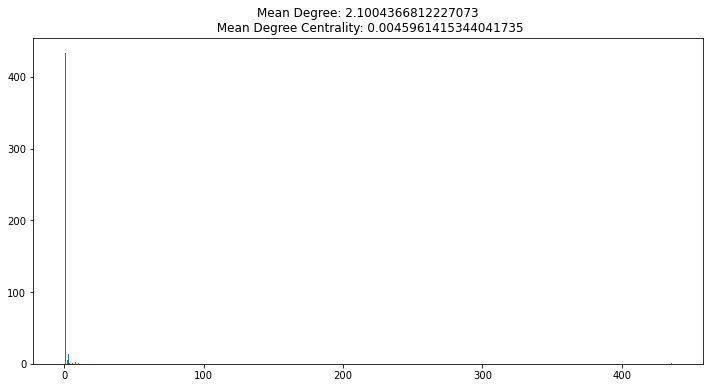

In [13]:
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.show()

In [23]:
# create a subgraph that only includes the classes Patient, ATCcode and PTCode
subtriples = g.triples((None, RDF.type, EX.Patients)) + g.triples((None, RDF.type, EX.Drug)) + g.triples((None, RDF.type, EX.Symptoms))
subgraph = rdflib_to_networkx_digraph(subtriples)

# visualize subgraph
nx.draw(subgraph, with_labels=True, node_size=1000, node_color='lightblue', font_size=8)

TypeError: unsupported operand type(s) for +: 'generator' and 'generator'

In [15]:
communities = nx_comm.louvain_communities(nx_graph,resolution=1) #resolution: high number favor small communitites, low favor large communities
print('Number of found communitites', len(communities))

for i in range(len(communities)):
    print(f'{i}th community: \n',communities[i] )

Number of found communitites 4
0th community: 
 {rdflib.term.Literal('4.84%'), rdflib.term.Literal('14.9%'), rdflib.term.Literal('9.75%'), rdflib.term.Literal('22.6%'), rdflib.term.Literal('3.45%'), rdflib.term.Literal('27%'), rdflib.term.Literal('very rare'), rdflib.term.Literal('10.2%'), rdflib.term.Literal('5.52%'), rdflib.term.Literal('5.69%'), rdflib.term.Literal('1.86%'), rdflib.term.Literal('8.8%'), rdflib.term.Literal('6%'), rdflib.term.Literal('0.965%'), rdflib.term.Literal('26.3%'), rdflib.term.Literal('27.1%'), rdflib.term.Literal('1.05%'), rdflib.term.Literal('4.55%'), rdflib.term.Literal('35%'), rdflib.term.Literal('2.72%'), rdflib.term.Literal('30%'), rdflib.term.Literal('5.78%'), rdflib.term.Literal('34%'), rdflib.term.Literal('4.92%'), rdflib.term.Literal('29.7%'), rdflib.term.Literal('34.4%'), rdflib.term.Literal('5.26%'), rdflib.term.Literal('3.56%'), rdflib.term.Literal('7.48%'), rdflib.term.Literal('14.1%'), rdflib.term.Literal('uncommon'), rdflib.term.Literal('8.62

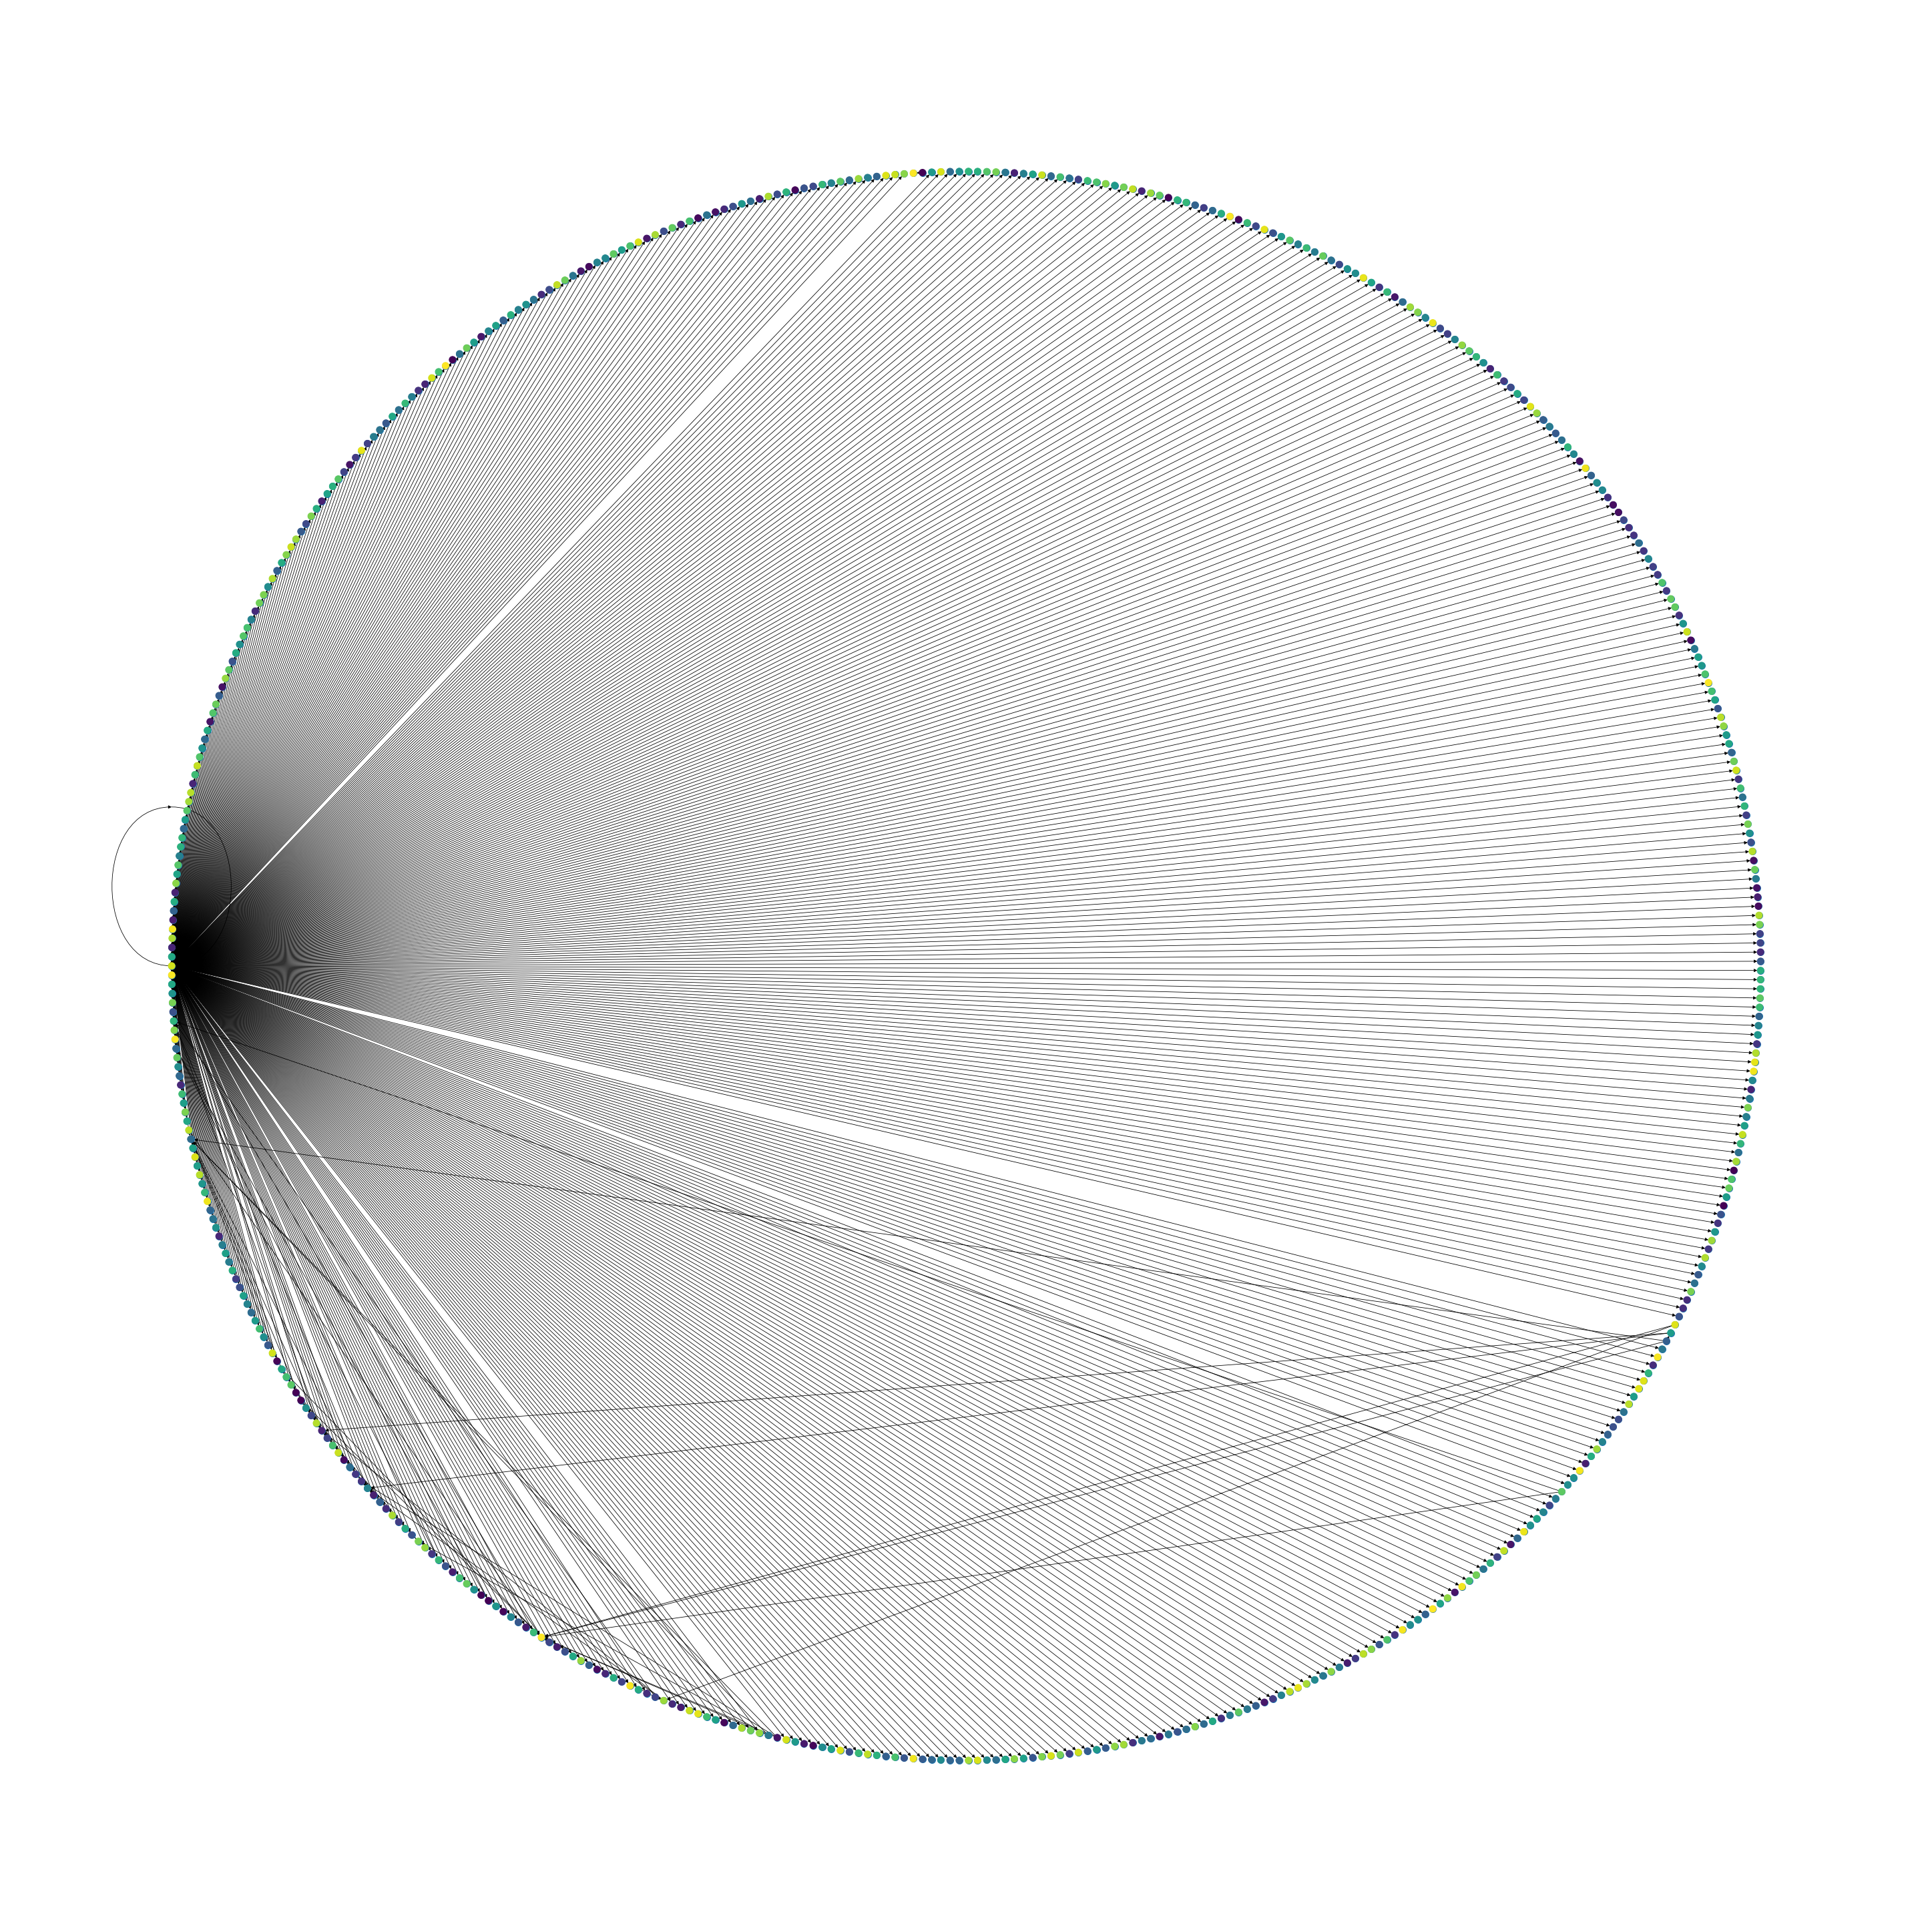

In [ ]:
pos = nx.shell_layout(nx_graph)
nx.draw(nx_graph, pos, edge_color='k',font_weight='light', 
        node_size= 100, width= 0.8)

for com in communities:
       nx.draw_networkx_nodes(nx_graph,
                           pos,
                           nodelist=com, 
                           node_color=range(len(com)),
                           label=True,
                           node_size=100)

In [ ]:
for com in communities:
    nx.draw_planar(nx_graph, with_labels=True,
                node_size=800, font_size=9 , font_color = "darkblue",nodelist = com, node_color=range(len(com)),alpha=0.6,linewidths=0.1,style=':')

In [ ]:
#Question
# why should we do clustering directlyon the graph and not on the data? 